In [3]:
from MDP import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from math import floor

(Creating Willemsen Gridworld)


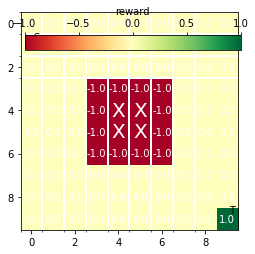

In [4]:
# Create the gridworld, and set cell values to equal rewards
print('(Creating Willemsen Gridworld)')
grid = np.ones((10, 10)) * 0
grid[3:7, 3:7] = -1
grid[9,9] = 1
terminal_state = np.array([[9,9]])
initial_state = np.array([1, 0])
blacked_state = np.array([[5,5], [4,5], [5,4], [4,4]])

fig, ax, im, cb = plot_gridworld(grid, terminal_state, initial_state, blacked_state, fig=None, ax=None, show=True)

In [5]:
n_episodes = 100
max_steps = 100
gamma = 0.8
alpha = 0.1

EXPLORATION_TYPE = 'GREEDY'

if EXPLORATION_TYPE == 'RANDOM':
    epsilons = np.ones(n_episodes)
elif EXPLORATION_TYPE == 'GREEDY':
    epsilons = np.flip(np.linspace(0.05, 1, n_episodes))

Learn = True
batch_size = 1
FILE_SIG = f"Results_n={n_episodes}, nB={batch_size}, exp={EXPLORATION_TYPE} GW2"

env = Gridworld(grid, terminal_state, initial_state, blacked_state, max_steps)

In [6]:
class Greedy(Agent):
    def combine_state_estimators(self, transition):
        # picks actions by maximising a random estimator
        maximizing_actions = []
        for E in self.estimators:
            action_values = E.evaluate(transition)
            max_value = max(action_values.values())
            max_actions = [k for k,v in action_values.items() if v == max_value]
            maximizing_actions.append(np.random.choice(max_actions))
        return np.random.choice(maximizing_actions)

In [7]:
class global_context(Mask):
    def apply(self, transition):
        context = 0
        return context

class Noveltor(Agent):
    def combine_state_estimators(self, transition):
        # Epsilon Greey Action Selection based on Q values
        if np.random.random() > 1 - self.epsilon:
            action = self.actions[np.random.randint(self.n_actions)]
        else:
            Qs = self.estimators[1].evaluate(transition)
            max_value = max(Qs.values())
            max_actions = [k for k,v in Qs.items() if v == max_value]
            action = np.random.choice(max_actions)
        return action

In [8]:
agent = Noveltor(estimators = [Estimator(approximator=bQt_novel_alpha(gamma=0.8), mask=identity()), 
                           Estimator(approximator=bellman_N_table(alpha=0.1, gamma=0.8), mask=identity()),
                           Estimator(global_N_abstractor(alpha=0.1, gamma=0.8), mask=global_context()),
                           Estimator(global_Q_abstractor(gamma=0.8), mask=global_context())],
                buffer = ReplayMemory(max_size=10000),
                targets = [Target()],
                counter = state_table(),
                batch_size=batch_size)

trajectories = []
metrics = []
for i in tqdm(range(n_episodes)):
    trajectory = run_trajectory(env, agent, epsilons[i], abstract=False)
    
    trajectories.append(trajectory)
    
    metrics.append({'Q': dict(agent.estimators[0].approximator.table), 
                    'N': dict(agent.estimators[1].approximator.table),
                    'Na': dict(agent.estimators[2].approximator.evaluate(0)),
                    'Qa': dict(agent.estimators[3].approximator.evaluate(0)),
                    'V': dict(agent.counter.table),
                    'U': dict(agent.estimators[0].visits)})

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
[ele['Q'] for ele in metrics]

[{},
 {(3, 0): {'up': nan, 'down': nan, 'left': nan, 'right': nan},
  (1, 0): {'up': nan, 'down': nan, 'left': nan, 'right': nan},
  (2, 0): {'up': nan, 'down': nan, 'left': nan, 'right': nan},
  (8, 0): {'up': nan, 'down': nan, 'left': nan, 'right': nan},
  (6, 0): {'up': nan, 'down': nan, 'left': nan, 'right': nan},
  (6, 1): {'up': nan, 'down': nan, 'left': nan, 'right': nan},
  (7, 1): {'up': nan, 'down': nan, 'left': nan, 'right': nan},
  (7, 0): {'up': nan, 'down': nan, 'left': nan, 'right': nan},
  (5, 0): {'up': nan, 'down': nan, 'left': nan, 'right': nan},
  (6, 2): {'up': nan, 'down': nan, 'left': nan, 'right': nan},
  (5, 2): {'up': nan, 'down': nan, 'left': nan, 'right': nan},
  (6, 3): {'up': nan, 'down': nan, 'left': nan, 'right': nan},
  (5, 3): {'up': nan, 'down': nan, 'left': nan, 'right': nan},
  (1, 2): {'up': nan, 'down': nan, 'left': nan, 'right': nan},
  (0, 2): {'up': nan, 'down': nan, 'left': nan, 'right': nan},
  (0, 0): {'up': nan, 'down': nan, 'left': nan, 'r

In [9]:
q_table = agent.estimators[0].approximator.table
visits = agent.counter.table
n_table = agent.estimators[1].approximator.table
n_visits = agent.estimators[1].visits

In [10]:
returns_table = cumulative_table(trajectories, gamma, Qpi_sa, q_table)
rho = state_dist(visits)
abs_action = action_abstraction(returns_table, rho)
sa_values, a_values, bias_squared = action_abstraction_bias(returns_table, abs_action)
heatmap = generate_heatmap(grid, rho)
heatmapQ = generate_heatmap(grid, q_table, aggf=lambda x: max(v for v in x.values()))
n_maps = {}
for a in agent.actions:
    n_maps[a] = generate_heatmap(grid, n_table, aggf=lambda x: x[a])
    
nt_maps = {}
for a in agent.actions:
    hm = np.copy(grid)*0
    for state, actions in n_visits.items():
        if a in list(actions.keys()):
            hm[state[0], state[1]] = actions[a]
    nt_maps[a] = hm

In [11]:
from matplotlib import animation, rc

dict_max = lambda x: max(v for v in x.values())
dict_mean = lambda x: sum(v for v in x.values())/len(x)
dict_min = lambda x: min(v for v in x.values())
dict_sum = lambda x: sum(v for v in x.values())

def generate_heatmap(grid, table, aggf=None, actions=False):
    if actions:
        hm = np.zeros((3,3))
        if aggf is None:
            aggf = lambda x: x

        hm[0,1] = table['up']
        hm[1,2] = table['right']
        hm[1,0] = table['left']
        hm[2,1] = table['down']

    else:
        hm = np.copy(grid) * 0
        if aggf is None:
            aggf = lambda x: x

        for k, v in table.items():
            hm[k] = aggf(v)

    return hm

def animate_values(data, estimator, fn=None):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(grid.shape[1], grid.shape[0]))

    for row in axs:
        for col in row:
            col.set_axis_off()

    ims = []
    for i in range(len(data)):
        
        imQ = axs[0, 0].imshow(generate_heatmap(grid=grid, table=data[i]['Q'], aggf=fn), animated=True, origin='upper')
        imN = axs[1, 0].imshow(generate_heatmap(grid=grid, table=data[i]['N'], aggf=fn), animated=True, origin='upper')
        imQa = axs[0, 1].imshow(generate_heatmap(grid=grid, table=data[i]['Qa'], actions=True), animated=True, origin='upper') 
        imNa = axs[1, 1].imshow(generate_heatmap(grid=grid, table=data[i]['Na'], actions=True), animated=True, origin='upper')
        imV = axs[2, 0].imshow(generate_heatmap(grid=grid, table=data[i]['V']), animated=True, origin='upper')
        imU = axs[2, 1].imshow(generate_heatmap(grid=grid, table=data[i]['U'], aggf=dict_sum), animated=True, origin='upper')
        ims.append([imQ, imN, imQa, imNa, imV, imU])
    
    fig.colorbar(imQ, ax=axs[0].ravel().tolist())
    fig.colorbar(imN, ax=axs[1].ravel().tolist())
    
    ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True, repeat_delay=1000)
    plt.close()

    return ani

estimator = ['Q', 'N']
ani = animate_values(metrics, estimator, fn=dict_max)

# Show the animation
# HTML(ani.to_html5_video())
# HTML(ani.to_jshtml())
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Cesare Carissimo'), bitrate=1800)
ani.save(f"{FILE_SIG}-%s.mp4" % estimator, writer=writer)

(Plotting 1 of 1)


<IPython.core.display.Javascript object>


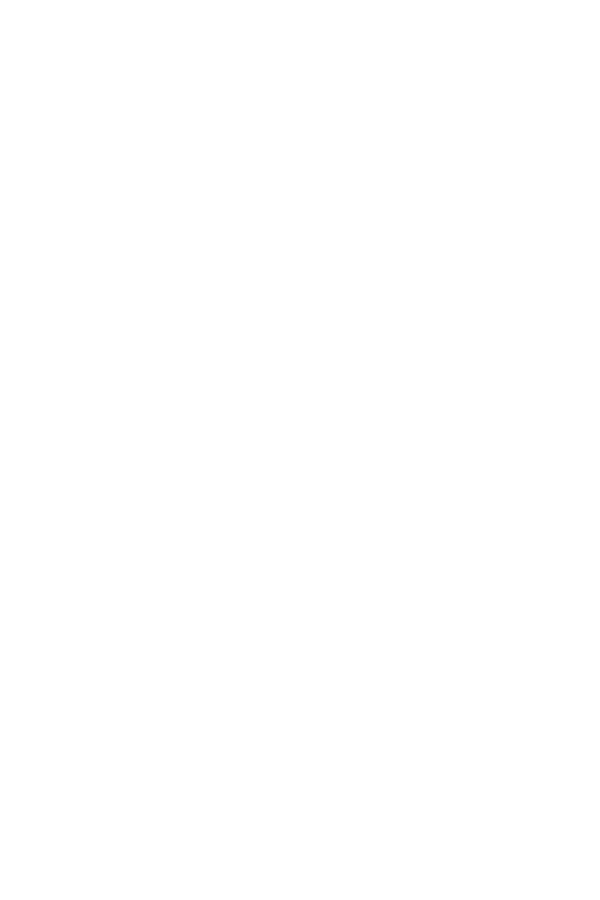

C:\Users\CesareCarissimo\Anaconda3\envs\marl\lib\site-packages\matplotlib\axes\_axes.py:6628: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\CesareCarissimo\Anaconda3\envs\marl\lib\site-packages\matplotlib\axes\_axes.py:6629: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

In [11]:
# First plot
%matplotlib notebook
print('(Plotting 1 of 1)')
fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(8, 12))

ax[0, 0].scatter(sa_values, a_values)
ax[0, 0].set_title('Bias plot')
ax[0, 0].set_xlabel('state action pair value')
ax[0, 0].set_ylabel('action abstraction value')
#ax[0, 0].set_ylim((0, 40))

ax[0, 1].hist(bias_squared, cumulative=True, bins=25)
ax[0, 1].set_title('Bias squared plot')
ax[0, 1].set_xlabel(r'$(v_{sa} - v_{a})^2$')
ax[0, 1].set_ylabel('freq')
# plt.ylim((0, 40))

ax[1, 0].imshow(heatmap, cmap='binary')
ax[1, 0].set_title('gridworld visits heatmap')

ax[1, 1].imshow(heatmapQ, cmap='binary')
ax[1, 1].set_title('gridworld qvalues')

ind = 4
for action, n_map in n_maps.items():
    x,y = (floor(ind/2), ind%2)
    ax[x,y].imshow(n_maps[action], cmap='binary')
    ax[x,y].set_title('n_values for action: %s' % action)
    ind += 1

for action, n_map in n_maps.items():
    x,y = (floor(ind/2), ind%2)
    ax[x,y].imshow(nt_maps[action], cmap='binary')
    ax[x,y].set_title('n_visits for action: %s' % action)
    ind += 1

plt.tight_layout()
plt.show()

In [11]:
d = defaultdict(float)
for a in env.actions:
    for s in n_table:
        d[a] += n_table[s][a] * rho[s]